# Multi-Label Movie Genre Classification
We import movie plot text and the respective movie genre. We build a multi-label text classification for the movie genre based on the plots. 

In this notebook, we build the classifier using BERT and pytorch frameworks.
 

# Importing libraries

In [ ]:
!pip install pytorch-lightning==1.2.8 transformers torchtext==0.6.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.9/841.9 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import json
import itertools
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

import tensorflow as tf
from transformers import AutoTokenizer, BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

# Import Data

In [ ]:
#Upload the dataset

#upload movie.metadata.tsv
meta = pd.read_csv("/content/drive/MyDrive/PROJECTS/DATASETS/movie.metadata.tsv", sep = '\t', header = None)
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
genres = meta[["movie_id","movie_name","genre"]]

#upload plot_summaries.txt
plots = pd.read_csv("/content/drive/MyDrive/PROJECTS/DATASETS/plot_summaries.txt", sep = '\t', header = None)
plots.columns = ["movie_id", "plot"]

#datatype conversions
genres['movie_id'] = genres['movie_id'].astype(str)
plots['movie_id'] = plots['movie_id'].astype(str)

#merge dataframes for final dataframe
df_movies = pd.merge(plots, genres, on = 'movie_id')

df_movies.head()

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [ ]:
#convert json objects into list of strings for columns-genre
genres_lists = []
for i in df_movies['genre']:
  genres_lists.append(list(json.loads(i).values()))

df_movies['genre'] = genres_lists

df_movies.head()

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"[Drama, World cinema]"
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"[Action/Adventure, Science Fiction, Action, Dr..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"[Screwball comedy, Comedy]"
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"[Crime Fiction, Drama, Docudrama, World cinema..."


### Data Exploration

Label(different genres) Distribution Exploration

In [ ]:
#convert column genre to list
genres_list=df_movies['genre'].tolist()
#flatten the list
genres_list_flattened= [item for sublist in genres_list for item in sublist]

#count frequency of each genre and create a dataframe
df_genre_count= pd.DataFrame([[x, genres_list_flattened.count(x)] for x in set(genres_list_flattened)], columns=['genre','count_of_movies'])
df_genre_count= df_genre_count.sort_values('count_of_movies', ascending= False)

df_genre_count.head(15)

,genre,count_of_movies
124,Drama,9173
128,Comedy,4998
23,Romance Film,3179
292,Thriller,3093
37,Action,2833
176,World cinema,2410
142,Crime Fiction,2065
88,Horror,1985
55,Black-and-white,1751
272,Indie,1712


In [ ]:
#Let's look at some distributive stats
print(df_genre_count.describe())

#calculting some other percentiles as well
percentiles = df_genre_count['count_of_movies'].quantile([0.85, 0.90, 0.95, 0.96, 0.97, 0.98, 0.99])
print(percentiles)

       count_of_movies
count       339.000000
mean        213.032448
std         705.457606
min           1.000000
25%           5.000000
50%          27.000000
75%         107.500000
max        9173.000000
0.85     261.70
0.90     422.60
0.95    1113.30
0.96    1368.64
0.97    1681.52
0.98    2004.20
0.99    2994.20
Name: count_of_movies, dtype: float64


Since the target variable 'genre' is highly imbalanced, let's proceed with considering only the genres which are above the 98th percentile.

By looking at their distributions, that means we consider the below 'top 8 genres' for the purposes of this project. 

In [ ]:
top8_genres= df_genre_count.head(8)['genre'].to_list()
top8_genres

['Drama',
 'Comedy',
 'Romance Film',
 'Thriller',
 'Action',
 'World cinema',
 'Crime Fiction',
 'Horror']

###Final Input Dataset
Creating the final dataset with consisting only the top 8 genres.

In [ ]:
#Convert list of strings into one-hot encoded columns
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit_transform(df_movies['genre'])

#transform target variable
y = multilabel_binarizer.transform(df_movies['genre'])

#adding classes as column names
for idx, genre in enumerate(multilabel_binarizer.classes_):
  df_movies[genre] = y[:,idx]

print(df_movies.shape)
df_movies.head()

(20187, 343)


,movie_id,plot,movie_name,genre,Absurdism,Acid western,Action,Action Comedy,Action Thrillers,Action/Adventure,...,Werewolf fiction,Western,Whodunit,Women in prison films,Workplace Comedy,World History,World cinema,Wuxia,Z movie,Zombie Film
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"[Drama, World cinema]",0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"[Action/Adventure, Science Fiction, Action, Dr...",0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"[Musical, Action, Drama, Bollywood]",0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"[Screwball comedy, Comedy]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"[Crime Fiction, Drama, Docudrama, World cinema...",0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
#Final Dataset- remove redundant columns & observations

cols_to_keep=['movie_id', 'plot', 'movie_name']
cols_to_keep.extend(top8_genres)

df_movies= df_movies[cols_to_keep]

#remove movies (rows) that have no genre in the top8_genre list
df_movies=df_movies.loc[(df_movies[top8_genres]!=0).any(1)]
df_movies

#the size of the dataframe has decreased
#the dataset now has atleast one genre (the top8 ones)

,movie_id,plot,movie_name,Drama,Comedy,Romance Film,Thriller,Action,World cinema,Crime Fiction,Horror
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,1,0,0,0,0,1,0,0
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,1,0,0,0,1,0,0,0
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,1,0,0,0,1,0,0,0
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,0,1,0,0,0,0,0,0
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
20181,26183012,Elif is a married woman who has just caught he...,Green Light,1,1,1,0,0,0,0,0
20182,16890025,Cantor Rabinowitz is upset that his son Joey ...,The Jazz Singer,1,1,0,0,0,0,0,0
20183,7194759,A man finds a lost boy in a war-torn village ...,The Record of a Tenement Gentleman,1,0,0,0,0,0,0,0
20185,1801280,{{Plot}} Michael Keaton and Teri Garr play Jac...,Mr. Mom,0,1,0,0,0,0,0,0


# Preprocess data

<Axes: >

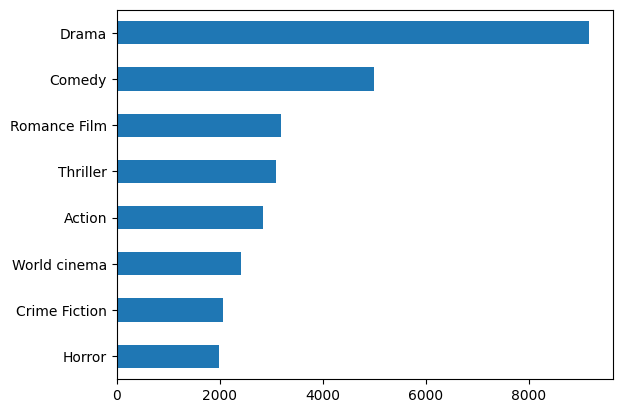

In [ ]:
#Let's look at the distribution of the labels:

LABEL_COLUMNS = df_movies.columns.tolist()[3:]
df_movies[LABEL_COLUMNS].sum().sort_values().plot(kind="barh")

In [ ]:
#Train- Validation Split

train_df, val_df = train_test_split(df_movies, test_size=0.05)
train_df.shape, val_df.shape

((15712, 11), (827, 11))

### **Tokenization**

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Let's look at a sample input and see how it is encoded using the above BERT tokenizer.


In [ ]:
sample_row = df_movies.iloc[16]
sample_plot = sample_row['plot']
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_plot)
print(sample_labels.to_dict())

Debbie's favorite band is Dream Street, and her favorite member is Chris Trousdale. When Chris gets a fever while travelling on the Dream Street tour, in a haze, he strays away and ends up in Debbie's bed, much to the shock of his "Biggest Fan," who thinks she's in heaven. Debbie proposes that Chris stay with her and he agrees. So, over the week they spend time together and she secretly hides him so he can escape the pressures of being a pop star for a little while. Chris even attends high school with Debbie, while disguised as a nerd. Meanwhile, the band's managers are going crazy at the loss of the star, thinking he has been kidnapped. At the end of the week Debbie and Chris  go to her high school prom where two jealous popular girls figure out Chris's true identity and tell the police about Chris's whereabouts, splitting him and Debbie up. They are eventually reunited on stage at a concert, ending in a sweet, final kiss and a performance by Dream Street.
{'Drama': 1, 'Comedy': 0, 'R

In [ ]:
#Encoding the sample

encoding = tokenizer.encode_plus(
  sample_plot,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
print(encoding.keys())

#Encoding 
print(encoding["input_ids"].shape, encoding["attention_mask"].shape)
print(encoding["input_ids"].squeeze()[:30])
print(encoding["attention_mask"].squeeze()[:30])

#Decoding
#Inverse the tokenization to get back to the words from the plot.
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:30])

dict_keys(['input_ids', 'attention_mask'])
torch.Size([1, 512]) torch.Size([1, 512])
tensor([  101, 17431,   112,   188,  5095,  1467,  1110,  6525,  1715,   117,
         1105,  1123,  5095,  1420,  1110,  2929,   157, 13149,  4319,   119,
         1332,  2929,  3370,   170, 10880,  1229,  9169,  1113,  1103,  6525])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
['[CLS]', 'Debbie', "'", 's', 'favorite', 'band', 'is', 'Dream', 'Street', ',', 'and', 'her', 'favorite', 'member', 'is', 'Chris', 'T', '##rous', '##dale', '.', 'When', 'Chris', 'gets', 'a', 'fever', 'while', 'travelling', 'on', 'the', 'Dream']


### **Dataset**

Wrapping the tokenization process in a PyTorch Dataset, along with converting labels to tensors.

In [ ]:
class MoviesPlotDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 512
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    plot_text = data_row['plot']
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      plot_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      plot_text=plot_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

Converting train and validation dataframes into PyTorch Datasets

In [ ]:
MAX_TOKEN_COUNT = 512

train_dataset = MoviesPlotDataset(
    train_df, 
    tokenizer, 
    max_token_len=MAX_TOKEN_COUNT)

val_dataset = MoviesPlotDataset(
    val_df, 
    tokenizer, 
    max_token_len=MAX_TOKEN_COUNT)

Let's look at a sample item from the dataset

In [ ]:
sample_item = train_dataset[0]
print(sample_item["plot_text"])
print(sample_item["input_ids"].shape)
print(sample_item["attention_mask"].shape)
print(sample_item["labels"])

Matrimony is not only a good thing, but also a good financial deal: Lawyer Dick Tyler  makes his merger bid for artist Doris  as his partner Jim Knight  squanders the firm's asset on gold-digger Evelyn .
torch.Size([512])
torch.Size([512])
tensor([1., 0., 0., 0., 0., 0., 0., 0.])


Load BERT model on the above sample data

In [ ]:
#Load BERT model
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

#BERT model on Sample data
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
print(sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape)

output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

#last hidden layer
print(output.last_hidden_state.shape, output.pooler_output.shape)

print(bert_model.config.hidden_size)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([8, 512]) torch.Size([8, 512])
torch.Size([8, 512, 768]) torch.Size([8, 768])
768



Wrap our dataset into LightningDataModule

In [ ]:
class MoviesPlotDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = MoviesPlotDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = MoviesPlotDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
#MoviesPlotDataModule has all data loading logic and return necessary data loaders, and below is a instance for our data module

N_EPOCHS = 1
BATCH_SIZE = 12

data_module = MoviesPlotDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

# Model
Our model uses a pre-trained BertModel and a linear layer to convert the BERT representation to a classification task. We'll pack everything in a LightningModule:

In [ ]:
class MoviesPlotTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

To use the scheduler, we need to calculate the number of training and warm-up steps. 
The number of training steps per epoch is equal to the number of training examples / by the batch size. The total number of training steps is equal to the training steps per epoch * by the number of epochs.

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
total_training_steps

1309

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(261, 1309)

Creating an instance for our model

In [ ]:
model = MoviesPlotTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Training

In [ ]:
#creating a checkpointing to save the best model based on validation loss

checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="movie-plots")
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

Training Process

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.core.lightning:
  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 6.2 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.266   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.distributed:Epoch 0, global step 1309: val_loss reached 0.31467 (best 0.31467), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


1

In [ ]:
trainer.test()

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3146733045578003}
--------------------------------------------------------------------------------


[{'test_loss': 0.3146733045578003}]

## Predictions

Let's load the best version of the model

In [ ]:
trained_model = MoviesPlotTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Let's test the model prediction on a sample data

In [ ]:
test_plot = "Abdur Rehman Khan , a middle-aged dry fruit seller from Afghanistan, comes to Calcutta to hawk his merchandise and befriends a small Bengali girl called Mini  who reminds him of his own daughter Amina back in Afghanistan. He puts up at a boarding house along with his countrymen. Since he is short of money he decides to sell his goods on credit for increasing his business. Later, when he goes to collect his money, one of his customers abuses him and in the fight that ensues Rehman warns that he will not tolerate abuse and stabs the man when he does not stop the abuse. In the court Rehman's lawyer tries to obfuscate the facts but in his characteristic and simple fashion Rehman states the truth in a matter of fact way. The judge, pleased with Rehman's honesty, gives him 10 years' rigorous imprisonment instead of the death sentence. On the day of his release, he goes to meet Mini but discovers that she has grown up into a woman and is about to get married. Mini does not recognize Rehman, who realises that his own daughter must have forgotten him too. Mini's father gives Rehman the money for travelling back to Afghanistan out of Mini's wedding budget to which Mini agrees; she also sends a gift for Rehman's daughter. The film ends with Rehman travelling back to his homeland."

encoding = tokenizer.encode_plus(
  test_plot,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

Drama: 0.8973667621612549
Comedy: 0.12284446507692337
Romance Film: 0.3067145347595215
Thriller: 0.04853951185941696
Action: 0.06421719491481781
World cinema: 0.39629703760147095
Crime Fiction: 0.062055669724941254
Horror: 0.00801627803593874


# Evaluation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)


In [ ]:
predictions = []
labels = []

for item in tqdm(val_dataset):
  _,prediction = trained_model(item["input_ids"].unsqueeze(dim=0).to(device)
                               ,item["attention_mask"].unsqueeze(dim=0).to(device))
          
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/827 [00:00<?, ?it/s]

In [ ]:
THRESHOLD=0.5
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.8614)

Since we have a imbalance data, let's look at ROC for each genre

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Drama: 0.8552485704421997
Comedy: 0.859458327293396
Romance Film: 0.8424566984176636
Thriller: 0.8712121248245239
Action: 0.9147225022315979
World cinema: 0.8344908952713013
Crime Fiction: 0.8934106230735779
Horror: 0.9873082637786865


Classification report for each genre

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

               precision    recall  f1-score   support

        Drama       0.76      0.84      0.80       457
       Comedy       0.80      0.53      0.64       247
 Romance Film       0.63      0.54      0.58       164
     Thriller       0.62      0.37      0.46       143
       Action       0.76      0.50      0.60       140
 World cinema       0.53      0.08      0.14       111
Crime Fiction       0.59      0.38      0.46        89
       Horror       0.81      0.84      0.83       110

    micro avg       0.73      0.59      0.65      1461
    macro avg       0.69      0.51      0.56      1461
 weighted avg       0.71      0.59      0.63      1461
  samples avg       0.75      0.65      0.66      1461



In [ ]:
#That gives us a much more realistic picture of the overall performance. 